Compute the MDS plot after having computed the dissimilarity matrices (see `compute_dsmroi_firstlev.py` script)

In [1]:
%pylab inline
#import matplotlib
#matplotlib.use('svg')
#import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
p = ['../', '/home/contematto/github/seaborn/']
for pp in p:
    if pp not in sys.path:
        sys.path.insert(1, pp)

In [3]:
import expdir
from mds_rois import bootstrap_mds, get_dsm_roi_xval1, dendrogram_dss_mvdoc, xboost, mdsf, \
                     plot_dsm, select_rois_pymvpa, get_minmax, mk_colorbar
from numpy.ma import masked_array
from mvpa2.suite import *
fns = expdir.expdir()
from scipy.spatial import distance as dist
from scipy.stats import scoreatpercentile
from matplotlib import cm

In [4]:
from os.path import join as pjoin

In [5]:
def load_dsm(subnr):
    fn = pjoin(fns.mvpadir(subnr), 'roi_rsa2/dsm_condition.hdf5')
    ds = h5load(fn)
    return ds

In [6]:
def make_ds_distance(ds, rank=False):
    if rank:
        ds_ = np.apply_along_axis(rankdata, 1, ds)
    else:
        ds_ = ds.samples
    ds_dist = squareform(pdist(ds_, metric='correlation'))
    return Dataset(ds_dist, sa=ds.sa, fa={'roi': ds.sa.targets})

In [7]:
# this contains the first level
roi_rdm = [load_dsm(i) for i in range(1, 34)]
# this contains the second level for each subject
roi_dist = [make_ds_distance(ds) for ds in roi_rdm]
#roi_dist = [make_ds_distance(ds, rank=True) for ds in roi_rdm]

In [8]:
# we compute distance then we average to obtain identity+familiarity effect
identity_distance = np.dstack(roi_dist).mean(axis=-1)
identity_distance = Dataset(identity_distance,
                            sa=roi_dist[0].sa,
                            fa={'roi': roi_dist[0].sa.targets})

In [9]:
def get_average_distance_ds(roi_rdm):
    """Generate a group distance matrix dataset"""
    dsms_avg = np.mean([pdist(ds, 'correlation') for ds in roi_rdm], axis=0)
    dsms_avg = squareform(dsms_avg)
    dsms_avg = Dataset(dsms_avg,
                       sa=roi_rdm[0].sa,
                       fa={'roi': roi_rdm[0].sa.targets})
    return dsms_avg

In [10]:
average_distance = get_average_distance_ds(roi_rdm)
average_distance_ = squareform(average_distance)

In [11]:
average_distance_.shape

(496,)

In [12]:
def get_bstrapped_adjacency(roi_rdm, nbs=10000, seed=7):
    """Bootstrap RDMs to obtain significant connections, and return
    an adjacency matrix with values corresponding to correlation"""
    # bootstrap
    nroi = len(roi_rdm[0])
    bootstraps_id = np.zeros((nbs, nroi * (nroi-1) / 2))
    np.random.seed(7)
    for i, bs in enumerate(xboost(len(roi_rdm), nbs)):
        bootstraps_id[i] = squareform(get_average_distance_ds([roi_rdm[b] for b in bs]))

    cis = scoreatpercentile(bootstraps_id, [2.5, 97.5], axis=0)
    sig_connection = np.zeros(cis.shape[1], dtype=int)

    for i, ci in enumerate(cis.T):
        if 1. < ci[0] or 1. > ci[1]:
            sig_connection[i] = 1.

    sig_connection = Dataset(squareform(sig_connection).astype(bool),
                        sa=roi_rdm[0].sa,
                        fa={'roi': roi_rdm[0].targets})
    
    adj = get_average_distance_ds(roi_rdm).samples
    adj = 1. - adj  # correlation
    adj[np.where(np.logical_not(sig_connection))] = 0.
    
    return adj

In [13]:
adj = get_bstrapped_adjacency(roi_rdm, nbs=10000)

In [14]:
distance_ds = get_average_distance_ds(roi_rdm)

In [15]:
# get coordinates
coordinates_mds = mdsf(distance_ds.samples, k=3)

# Plot MDS with lines

In [16]:
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [17]:
labels = distance_ds.sa.targets.copy()

In [18]:
coordinates = coordinates_mds#[:, :2]

In [19]:
import seaborn as sns
sns.set(style='white')

In [20]:
cmap = plt.cm.YlOrRd

In [21]:
# modified from https://github.com/kingjr/jr-tools/blob/master/jr/plot/base.py#L232
def pretty_plot(ax=None):
    if ax is None:
        plt.gca()
    ax.tick_params(colors='dimgray')
    ax.xaxis.label.set_color('dimgray')
    ax.yaxis.label.set_color('dimgray')
    try:
        ax.zaxis.label.set_color('dimgray')
    except AttributeError:
        pass
    try:
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
    except ValueError:
        pass
    ax.spines['left'].set_color('dimgray')
    ax.spines['bottom'].set_color('dimgray')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

In [22]:
def plot_mds(coordinates, adj, labels, labels_color=None, 
             cmap=plt.cm.hot_r, view=(30, 20), plot_lines=True):
    fig = plt.figure(figsize=(16, 12))
    nd = coordinates.shape[1]
    if nd == 3:
        ax = fig.add_subplot(111, projection='3d')
    elif nd == 2:
        ax = fig.add_subplot(111)
    else:
        raise ValueError('Cannot plot {0}-d image'.format(nd))

    # I should receive a set of coordinates, a set of labels, and an adjacency matrix
    assert(len(coordinates) == len(labels))
    assert(adj.shape[0] == len(coordinates))

    # plot lines first -- thanks Gael
    nonzero = (np.abs(np.triu(adj, k=1)) > 0)
    start_idx, end_idx = np.where(nonzero)
    lines = [[coordinates[start], coordinates[end]] 
             for start, end in zip(start_idx, end_idx)]
    values = np.abs(adj[nonzero])

    norm = mpl.colors.Normalize(vmin=0., vmax= .7 * values.max())
    norm_alpha = mpl.colors.Normalize(vmin=0, vmax=values.max() * .6,
                                      clip=True)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)

    linewidth_mult = 15
    if plot_lines:
        if nd == 2:
            for ((xs, ys), (xe, ye)), value in zip(lines, values):
                ax.plot([xs, xe], [ys, ye], 
                        color=m.to_rgba(value),
                        alpha=norm_alpha(value),
                        linewidth=value*linewidth_mult
                        )
        else:
            for ((xs, ys, zs), (xe, ye, ze)), value in zip(lines, values):
                ax.plot([xs, xe], [ys, ye], [zs, ze], 
                        color=m.to_rgba(value),
                        alpha=norm_alpha(value),
                        linewidth=value*linewidth_mult
                        )

    #then points
    if nd == 3:
        ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], s=100, c='k')
    else:
        ax.scatter(coordinates[:, 0], coordinates[:, 1], s=100, c='k')

    # finally labels
    text_kwargs = dict(fontsize=16,
                    bbox=dict(facecolor='white', alpha=0.8),
                    horizontalalignment='center',
                    verticalalignment='center')
    
    if labels_color is None:
        labels_color = ['black'] * len(labels)
    if nd == 3:
        for ((x, y, z), label, color) in zip(coordinates, labels, labels_color):
             ax.text(x, y, z, label, color=color, **text_kwargs)
    else:
        for ((x, y), label, color) in zip(coordinates, labels, labels_color):
            ax.text(x, y, label, color=color, **text_kwargs)

    if nd == 3:
        ax.view_init(*view)
        
    pretty_plot(ax)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    return fig#, ax

In [23]:
def savefig(fig, name):
    outdir = 'mds_plots'
    outfn = pjoin(outdir, name + '.{0}')
    for ext in ['png', 'svg', 'tiff']:
        fig.savefig(outfn.format(ext), dpi=300)

In [24]:
for l in labels:
    print("'{0}': ,".format(l))

'rLingual': ,
'lParaCin': ,
'rIFG': ,
'raParaCin': ,
'lTPJ': ,
'rEV-Id': ,
'lpFFA': ,
'rOFA-Id': ,
'ldPreCun': ,
'lFFA-Id': ,
'laFFA': ,
'lpMTG': ,
'lEV-Id': ,
'lmMTG': ,
'raMTG': ,
'rATL-Id': ,
'raFFA': ,
'rpFFA': ,
'rTPJ': ,
'lvPreCun': ,
'rpMTG': ,
'rdPreCun-Id': ,
'lIFG': ,
'rmMTG': ,
'rvPreCun': ,
'rFFA-Id': ,
'lOFA-Id': ,
'lLingual': ,
'laMTG': ,
'ldPreCun-Id': ,
'lIFG-Id': ,
'rdPreCun': ,


In [25]:
# assign a color to each label to represent a group of ROIs
# green: core system
# purple: extended system
green = '#1b9e77'
purple = '#7570b3'

label2color = {
'rLingual': green,
'lParaCin': purple,
'lLingual': green,
'rIFG': purple,
'raParaCin': purple,
'lParaHipp': purple,
'rEV-Id': green,
'lpFFA': green,
'lEV-Id': green,
'ldPreCun': purple,
'lFFA-Id': green,
'laFFA': green,
'lpMTG': green,
'lmMTG': purple,
'raMTG': purple,
'rATL-Id': purple,
'raFFA': green,
'rpFFA': green,
'rTPJ': purple,
'lvPreCun': purple,
'rpMTG': green,
'rdPreCun-Id': purple,
'lIFG': purple,
'rmMTG': purple,
'rvPreCun': purple,
'rFFA-Id': green,
'lTPJ': purple,
'rParaHipp': purple,
'laMTG': purple,
'ldPreCun-Id': purple,
'lIFG-Id': purple,
'rdPreCun': purple,
'rOFA-Id': green,
'lOFA-Id': green,
}

In [26]:
labels_color = [label2color[lbl] for lbl in labels]

In [27]:
assert(len(labels) == len(labels_color))

In [28]:
# swap first coordinate so EV is on the left
coordinates[:, 0] *= -1

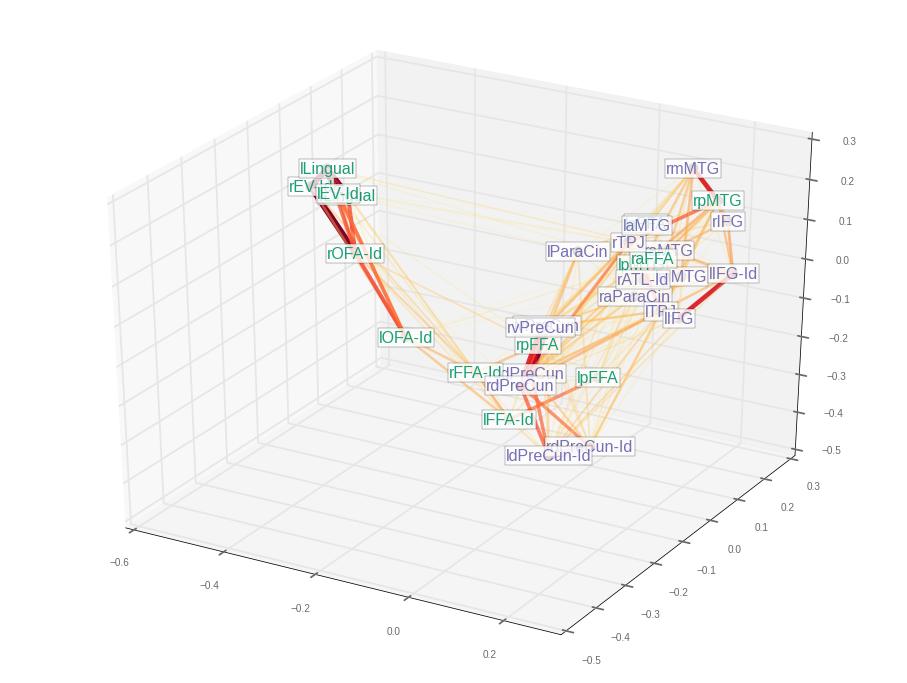

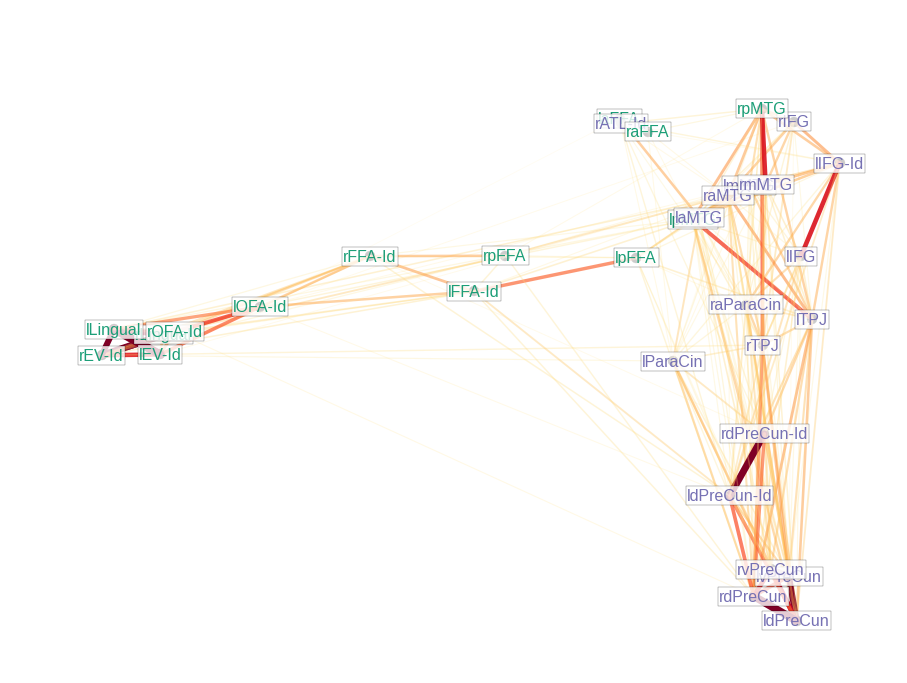

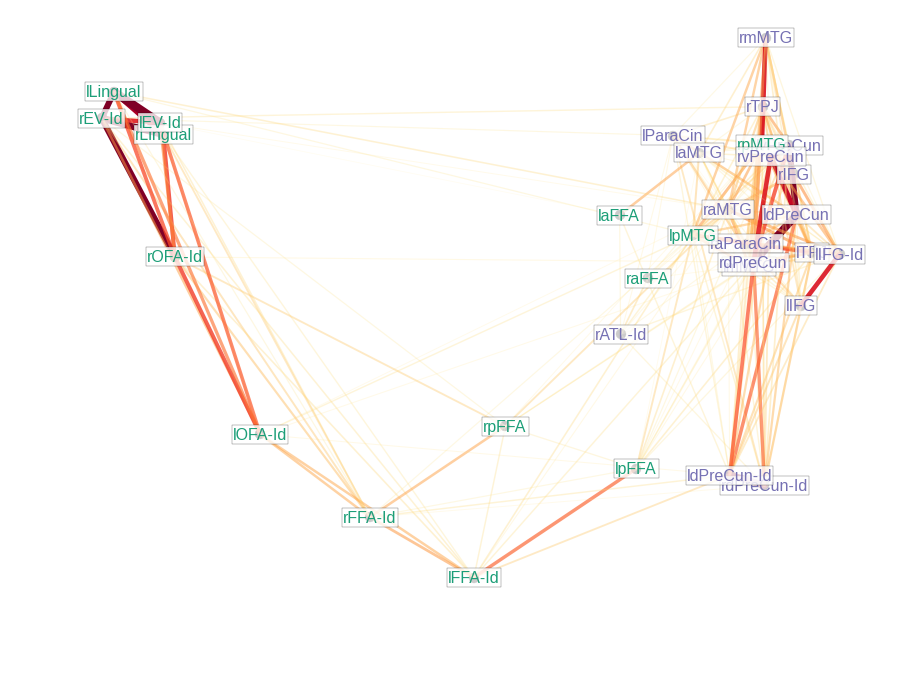

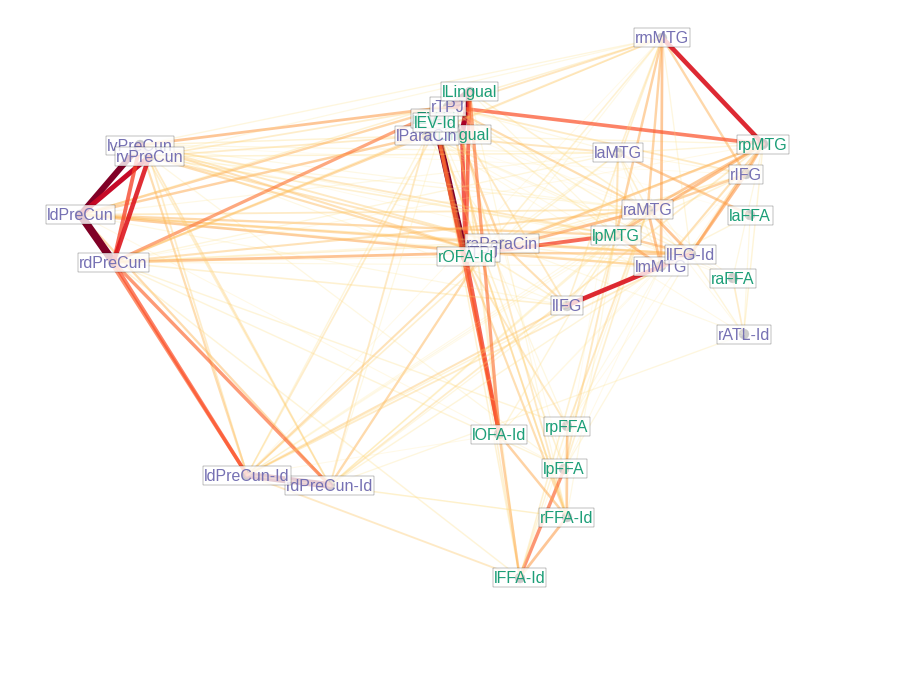

In [29]:
figs_mds = []

figs_mds.append(plot_mds(coordinates, adj, labels, labels_color=labels_color,
                         cmap=cmap, view=(30, -60)));
figs_mds.append(plot_mds(coordinates[:, [0, 1]], adj, labels, labels_color=labels_color,
                         cmap=cmap));
figs_mds.append(plot_mds(coordinates[:, [0, 2]], adj, labels, labels_color=labels_color,
                         cmap=cmap));
figs_mds.append(plot_mds(coordinates[:, [1, 2]], adj, labels, labels_color=labels_color,
                         cmap=cmap));

In [30]:
figs_names = ['3d', '12', '13', '23']
for fig, name in zip(figs_mds, figs_names):
    savefig(fig, 'allroi-mds-fullrdm_{0}'.format(name))

# Use Seaborn to make a nice plot of the correlation matrix

In [31]:
from scipy.stats import rankdata

In [34]:
def make_corrplot(distances, adj, mask_lower=False, percentiles=False):
    # get the full matrix
    labels = distances.fa.roi
    distances = distances.samples.copy()
    if percentiles:
        distances_ = squareform(distances, checks=False)
        distances_ = rankdata(distances_)/len(distances_)
        distances = squareform(distances_)
        # add 1. to the diagonal
        #np.fill_diagonal(distances, 1.)
        mx = 1.
    else:
        # make it a correlation
        distances = 1 - distances
        mx = np.triu(distances, k=1).max() * .7
    # mask only the lower diagonal
    mask = np.zeros_like(distances, dtype=np.bool)
    if mask_lower:
        mask[np.tril_indices_from(mask)] = True
        mask = np.logical_and(np.tril(mask), np.logical_not(adj != 0.))
        # keep the diagonal
        np.fill_diagonal(mask, False)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    #reorder the labels in a sensible organization
    labels_ord = [
        'lEV-Id', 'lLingual',
        'rEV-Id', 'rLingual',
        'lOFA-Id', 'rOFA-Id',
        'ldPreCun', 'ldPreCun-Id',  'lvPreCun',
        'rdPreCun', 'rdPreCun-Id',  'rvPreCun',
        'lFFA-Id', 'rFFA-Id',
        'lpFFA', 'rpFFA',
        'laFFA', 'raFFA',
        'lTPJ', 'rTPJ',
        'lpMTG', 'rpMTG',
        'lmMTG', 'rmMTG',
        'laMTG', 'raMTG',
        'rATL-Id',
        'lIFG-Id', 'lIFG',
        'rIFG',
        'lParaCin',
        'raParaCin',]
    # get only labels we have
    labels_ord = [l for l in labels_ord if l in labels]

    # get reordered idx
    order = [np.where(l == labels)[0][0] for l in labels_ord]
    distances_ord = distances.copy()
    mask_ord = mask.copy()

    distances_ord = distances_ord[order, :][:, order]
    mask_notsig = np.logical_not(adj != 0.)
    np.fill_diagonal(mask_notsig, False)
    mask_notsig = mask_notsig[:, order][order, :]
    mask_notsig[np.triu_indices_from(mask_notsig, k=1)] = False
    sns.set(style='white', context='poster')
    f, ax = plt.subplots(figsize=(14, 11))
    
    sns.heatmap(distances_ord, mask=mask_ord, cmap=cmap, 
            vmax=mx,
            square=True, ax=ax,
            xticklabels=labels_ord, yticklabels=labels_ord,
            linewidths=.5,
            cbar_kws={"shrink": .95,
                      "ticks": np.round(np.linspace(-mx, mx, 9), 2)},
            rasterized=True,
            )
    return f

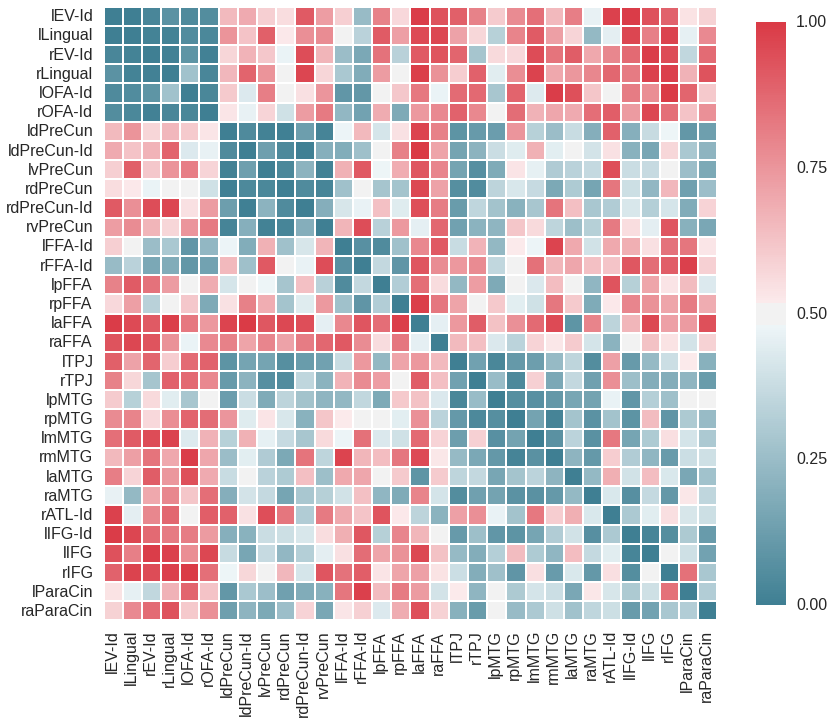

In [35]:
f_all = make_corrplot(distance_ds, adj, percentiles=True)

In [36]:
import pandas as pd
from scipy.cluster.hierarchy import linkage

In [38]:
def make_clustermap(distances, adj, mask_lower=False, percentiles=False):
    # get the full matrix
    labels = distances.fa.roi
    distances = distances.samples.copy()
    if percentiles:
        distances_ = squareform(distances, checks=False)
        distances_ = rankdata(distances_)/len(distances_)
        distances = squareform(distances_)
        # add 1. to the diagonal
        #np.fill_diagonal(distances, 1.)
        mx = 1.
    else:
        # make it a correlation
        distances = 1 - distances
        mx = np.triu(distances, k=1).max() * .7
    # mask only the lower diagonal
    mask = np.zeros_like(distances, dtype=np.bool)
    if mask_lower:
        mask[np.tril_indices_from(mask)] = True
        mask = np.logical_and(np.tril(mask), np.logical_not(adj != 0.))
        # keep the diagonal
        np.fill_diagonal(mask, False)
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    #reorder the labels in a sensible organization
    labels_ord = [
        'lEV-Id', 'lLingual',
        'rEV-Id', 'rLingual',
        'lOFA-Id', 'rOFA-Id',
        'ldPreCun', 'ldPreCun-Id',  'lvPreCun',
        'rdPreCun', 'rdPreCun-Id',  'rvPreCun',
        'lFFA-Id', 'rFFA-Id',
        'lpFFA', 'rpFFA',
        'laFFA', 'raFFA',
        'lTPJ', 'rTPJ',
        'lpMTG', 'rpMTG',
        'lmMTG', 'rmMTG',
        'laMTG', 'raMTG',
        'rATL-Id',
        'lIFG-Id', 'lIFG',
        'rIFG',
        'lParaCin',
        'raParaCin',]
    # get only labels we have
    labels_ord = [l for l in labels_ord if l in labels]

    # get reordered idx
    order = [np.where(l == labels)[0][0] for l in labels_ord]
    distances_ord = distances.copy()
    mask_ord = mask.copy()

    distances_ord = distances_ord[order, :][:, order]
    mask_notsig = np.logical_not(adj != 0.)
    np.fill_diagonal(mask_notsig, False)
    mask_notsig = mask_notsig[:, order][order, :]
    mask_notsig[np.triu_indices_from(mask_notsig, k=1)] = False
    sns.set(style='white', context='poster')

    # make a pandas dataset to use clustermap
    df = pd.DataFrame(distances_ord, index=labels_ord, columns=labels_ord)
    # get linkage
    link_ds = linkage(distance_ds.samples[order, :][:, order], method='average')
    f = sns.clustermap(df, mask=mask_ord, cmap=cmap, 
            vmax=mx,
            square=True,
            #xticklabels=labels_ord, yticklabels=labels_ord,
            linewidths=.5,
            cbar_kws={"ticks": np.round(np.linspace(-mx, mx, 9), 2)},
            rasterized=True,
            col_linkage=link_ds,
            row_linkage=link_ds,
            figsize=(11, 11)
            )    
    return f

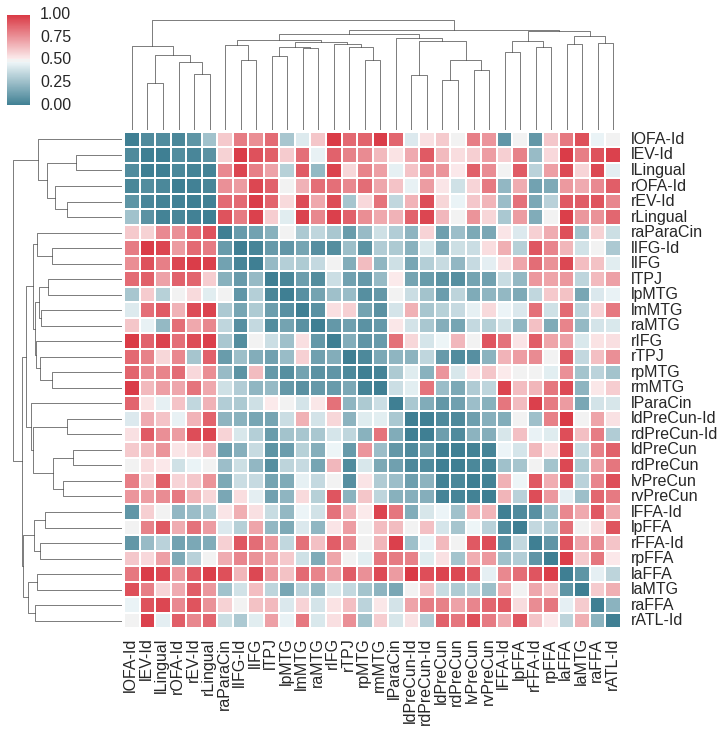

In [39]:
f = make_clustermap(distance_ds, adj, percentiles=True)

In [40]:
f.savefig('clustermap_allroi.png', dpi=300)